<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-25-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,totalTestResults
37,NY,291996,534099,826095.0
34,NJ,111188,116587,227775.0
21,MA,56462,188425,244887.0
16,IL,45883,181745,227628.0
5,CA,43464,509945,553409.0
41,PA,42050,161372,203422.0
24,MI,38210,119550,157760.0
10,FL,32138,324325,356463.0
20,LA,27068,119921,146989.0
47,TX,25297,265220,290517.0


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death','positiveIncrease', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-14:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
83,2020-04-14,602668,3125731.0,26066,25793.0,2312.0,0.614257
84,2020-04-15,633112,3262564.0,28564,30444.0,2498.0,0.645286
85,2020-04-16,664129,3424690.0,30722,31017.0,2158.0,0.676899
86,2020-04-17,695761,3582610.0,32785,31632.0,2063.0,0.709140
87,2020-04-18,723776,3724925.0,34557,28015.0,1772.0,0.737693
88,2020-04-19,751287,3891383.0,36224,27511.0,1667.0,0.765733
89,2020-04-20,776419,4038895.0,37913,25132.0,1689.0,0.791349
90,2020-04-21,802330,4186974.0,40471,25911.0,2558.0,0.817758
91,2020-04-22,830223,4501156.0,42508,27893.0,2037.0,0.846187
92,2020-04-23,861788,4693168.0,44385,31565.0,1877.0,0.878359


In [9]:
dfCAPos[-7:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
48,2020-04-21,33261,300100.0,1268,2283.0,60.0,0.765254
49,2020-04-22,35396,465327.0,1354,2135.0,86.0,0.814375
50,2020-04-23,37369,482097.0,1469,1973.0,115.0,0.859769
51,2020-04-24,39254,494173.0,1562,1885.0,93.0,0.903138
52,2020-04-25,41137,506035.0,1651,1883.0,89.0,0.946461
53,2020-04-26,42164,526084.0,1710,1027.0,59.0,0.970090
54,2020-04-27,43464,553409.0,1755,1300.0,45.0,1.000000


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-23,861788,3831380,4258,57840.0,91108.0,15163.0,2428.0,5464.0,227.0,61837.0,44385,91108.0,4697426,4693168.0,4693168.0,1877.0,1345.0,160447.0,31565.0,192012.0
2020-04-24,896306,4029087,4396,56075.0,93366.0,15078.0,2468.0,5187.0,227.0,79248.0,46251,93366.0,4929789,4925393.0,4925393.0,1866.0,2258.0,197707.0,34518.0,232225.0
2020-04-25,932242,4264407,5315,56344.0,94743.0,15020.0,2516.0,5266.0,227.0,88735.0,48069,94743.0,5201964,5196649.0,5196649.0,1818.0,1377.0,235320.0,35936.0,271256.0
2020-04-26,959258,4443794,4445,55030.0,95810.0,14831.0,2571.0,5121.0,227.0,91001.0,49164,95810.0,5407497,5403052.0,5403052.0,1095.0,1067.0,179387.0,27016.0,206403.0
2020-04-27,981134,4612361,4077,54971.0,97782.0,9655.0,3720.0,4867.0,195.0,94745.0,50327,97782.0,5597572,5593495.0,5593495.0,1163.0,2263.0,168567.0,21876.0,190443.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-23,37369,444728,0,4929.0,0.0,1531.0,0.0,0.0,0.0,0.0,1469,0.0,482097,482097.0,482097.0,115.0,0.0,14797.0,1973.0,16770.0
2020-04-24,39254,454919,0,4880.0,0.0,1521.0,0.0,0.0,0.0,0.0,1562,0.0,494173,494173.0,494173.0,93.0,0.0,10191.0,1885.0,12076.0
2020-04-25,41137,464898,0,4847.0,0.0,1458.0,0.0,0.0,0.0,0.0,1651,0.0,506035,506035.0,506035.0,89.0,0.0,9979.0,1883.0,11862.0
2020-04-26,42164,483920,0,4928.0,0.0,1473.0,0.0,0.0,0.0,0.0,1710,0.0,526084,526084.0,526084.0,59.0,0.0,19022.0,1027.0,20049.0
2020-04-27,43464,509945,0,4878.0,0.0,1499.0,0.0,0.0,0.0,0.0,1755,0.0,553409,553409.0,553409.0,45.0,0.0,26025.0,1300.0,27325.0


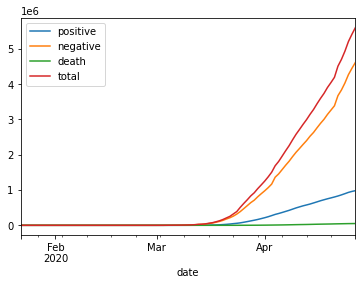

In [12]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [13]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-14,553822,21972
2020-04-15,578268,23476
2020-04-16,604070,25871
2020-04-17,632781,28221
2020-04-18,665330,30384
2020-04-19,695353,32427
2020-04-20,723605,34203
2020-04-21,751273,35884
2020-04-22,776907,37602


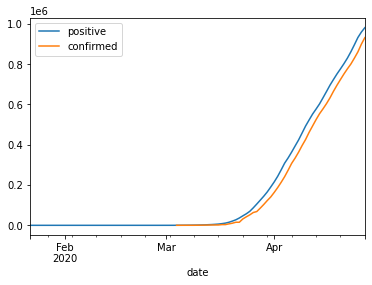

In [14]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [15]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-21,33261,266839,0,4886.0,0.0,1502.0,0.0,0.0,0.0,0.0,1268,0.0,300100,300100.0,300100.0,60.0,0.0,7317.0,2283.0,9600.0
2020-04-22,35396,429931,0,4984.0,0.0,1551.0,0.0,0.0,0.0,0.0,1354,0.0,465327,465327.0,465327.0,86.0,0.0,163092.0,2135.0,165227.0
2020-04-23,37369,444728,0,4929.0,0.0,1531.0,0.0,0.0,0.0,0.0,1469,0.0,482097,482097.0,482097.0,115.0,0.0,14797.0,1973.0,16770.0
2020-04-24,39254,454919,0,4880.0,0.0,1521.0,0.0,0.0,0.0,0.0,1562,0.0,494173,494173.0,494173.0,93.0,0.0,10191.0,1885.0,12076.0
2020-04-25,41137,464898,0,4847.0,0.0,1458.0,0.0,0.0,0.0,0.0,1651,0.0,506035,506035.0,506035.0,89.0,0.0,9979.0,1883.0,11862.0
2020-04-26,42164,483920,0,4928.0,0.0,1473.0,0.0,0.0,0.0,0.0,1710,0.0,526084,526084.0,526084.0,59.0,0.0,19022.0,1027.0,20049.0
2020-04-27,43464,509945,0,4878.0,0.0,1499.0,0.0,0.0,0.0,0.0,1755,0.0,553409,553409.0,553409.0,45.0,0.0,26025.0,1300.0,27325.0


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    938154
dead          53755
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    42368
dead          1689
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                938154
Spain             223759
Italy             195351
France            161644
Germany           156513
United Kingdom    149569
Turkey            107773
Iran               89328
China              83909
Russia             74588
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [24]:
dfState.loc['FL'].head(7)

,date,positive,death,current_total,pct
state,,,,,
FL,2020-04-27,32138,1101,32138,1.000000
FL,2020-04-26,31528,1094,32138,0.981019
FL,2020-04-25,30839,1075,32138,0.959581
FL,2020-04-24,30174,1031,32138,0.938889
FL,2020-04-23,28832,979,32138,0.897131
FL,2020-04-22,28309,910,32138,0.880858
FL,2020-04-21,27495,856,32138,0.855529


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

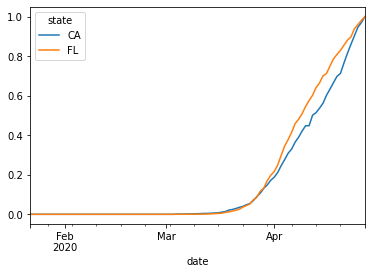

In [26]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

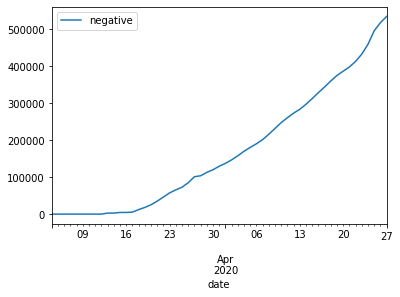

In [28]:
x = dfNYTesting.plot.line()

In [29]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,current_total,pct
524,FL,2020-04-27,32138,1101,32138,1.000000
525,FL,2020-04-26,31528,1094,32138,0.981019
526,FL,2020-04-25,30839,1075,32138,0.959581
527,FL,2020-04-24,30174,1031,32138,0.938889
528,FL,2020-04-23,28832,979,32138,0.897131
529,FL,2020-04-22,28309,910,32138,0.880858
530,FL,2020-04-21,27495,856,32138,0.855529
531,FL,2020-04-20,26660,806,32138,0.829548
532,FL,2020-04-19,25996,781,32138,0.808887
533,FL,2020-04-18,25269,754,32138,0.786265


In [30]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,death,current_total,pct


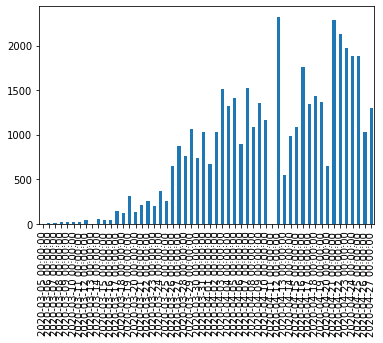

In [31]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [34]:
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")

positive     981134
negative    4612361
pending        4077
death         50327
total       5597572
dtype: int64
Current Infection Rate 17.527850%
Percentage of US affected: 0.314240%
Percentage of US tested/affected: 1.719422%


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [42]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.500990,4.246498
NJ,1.251808,2.564401
MA,0.819180,3.552947
RI,0.727608,5.275350
CT,0.708751,2.238558
LA,0.582259,3.161874
DC,0.551471,2.609426
DE,0.427414,2.014451
MI,0.382603,1.579676


In [43]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 1.704089%


In [44]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [46]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13675 entries, 0 to 13674
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  13492 non-null  object 
 1   location                  13675 non-null  object 
 2   date                      13675 non-null  object 
 3   total_cases               13675 non-null  int64  
 4   new_cases                 13675 non-null  int64  
 5   total_deaths              13675 non-null  int64  
 6   new_deaths                13675 non-null  int64  
 7   total_cases_per_million   13394 non-null  float64
 8   new_cases_per_million     13394 non-null  float64
 9   total_deaths_per_million  13395 non-null  float64
 10  new_deaths_per_million    13395 non-null  float64
 11  total_tests               3259 non-null   float64
 12  new_tests                 2907 non-null   float64
 13  total_tests_per_thousand  3259 non-null   float64
 14  new_te

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [48]:
dfOwidTests.date.max()

'2020-04-27'

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [50]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    5441079.0
RUS    3019434.0
DEU    2072669.0
ITA    1757659.0
ESP    1035522.0
         ...    
CRI       8872.0
SEN       8358.0
PRY       7615.0
MMR       6678.0
BOL       5791.0
Name: total_tests, Length: 78, dtype: float64

In [51]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 18896855
Total tests done in USA : 5441079
How many more times has the world tested more than the US: 3.5


In [52]:
dfOwid.iso_code.nunique()

207

In [53]:
dfOwid.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
